# CPU & Memory

- Modification: filtrage des valeurs égales à 0
- ajout de .cache()

In [2]:
!which python

/mnt/lustre/scratch/nlsas/home/ulc/cursos/curso341/miniconda3/envs/DaskOnRay38/bin/python


# Cleaning

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, BooleanType, StringType

In [4]:
# Task usage
csv_directory_task_usage = "/mnt/lustre/scratch/nlsas/home/ulc/cursos/curso341/Big_Data_Frameworks/data/task_usage/*.csv"
# Task event
csv_directory_task_events = "/mnt/lustre/scratch/nlsas/home/ulc/cursos/curso341/Big_Data_Frameworks/data/task_events/*.csv"


## Task Usage

In [5]:
# Initialiser une session Spark
spark = SparkSession.builder \
    .appName("Analyse Memory & CPU Usage (Jobs & Tasks)") \
    .getOrCreate()

# Définition du schéma pour les fichiers CSV
task_usage_schema = StructType([
    StructField("start time", IntegerType(), True),
    StructField("end time", IntegerType(), True),
    StructField("job ID", IntegerType(), True),
    StructField("task index", IntegerType(), True),
    StructField("machine ID", IntegerType(), True),
    StructField("CPU rate", FloatType(), True),
    StructField("canonical memory usage", FloatType(), True),
    StructField("assigned memory usage", FloatType(), True),
    StructField("unmapped page cache", FloatType(), True),
    StructField("total page cache", FloatType(), True),
    StructField("maximum memory usage", FloatType(), True),
    StructField("disk I/O time", FloatType(), True),
    StructField("local disk space usage", FloatType(), True),
    StructField("maximum CPU rate", FloatType(), True),
    StructField("maximum disk IO time", FloatType(), True),
    StructField("cycles per instruction", FloatType(), True),
    StructField("memory accesses per instruction", FloatType(), True),
    StructField("sample portion", FloatType(), True),
    StructField("aggregation type", BooleanType(), True),
    StructField("sampled CPU usage", FloatType(), True)
])

# Lire les fichiers CSV en un DataFrame avec le schéma défini
df_task_usage = spark.read.csv(csv_directory_task_usage, header=False, schema=task_usage_schema)

#print(f"Nombre total de lignes combinées (sans nettoyage) : {df_task_usage.count()}") #1232799308
# Filtrer pour supprimer les lignes où job ID est nul
df_task_usage_cleaned = df_task_usage.filter(
    F.col("job ID").isNotNull() &
    (F.col("canonical memory usage") > 0) &
    (F.col("sampled CPU usage") > 0)
)#.na.drop(subset=["canonical memory usage", "sampled CPU usage"])

#print(f"Nombre total de lignes combinées (avec nettoyage) : {df_task_usage_cleaned.count()}") #7901086

# Sélectionner les colonnes pertinentes
df_task_usage_cleaned_selected = df_task_usage_cleaned.select(
    "start time", "end time", "job ID", "task index", 
    "canonical memory usage", "sampled CPU usage"
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/01 11:42:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Task Event

In [6]:
# Définition du schéma pour les fichiers CSV
task_events_schema = StructType([
    StructField("timestamp", IntegerType(), True),
    StructField("missing info", IntegerType(), True),
    StructField("job ID", IntegerType(), True),
    StructField("task index", IntegerType(), True),
    StructField("machine ID", IntegerType(), True),
    StructField("event type", IntegerType(), True),
    StructField("user name", StringType(), True),
    StructField("scheduling class", IntegerType(), True),
    StructField("priority", IntegerType(), True),
    StructField("resource request for CPU cores", FloatType(), True),
    StructField("resource request for RAM", FloatType(), True),
    StructField("resource request for local disk space", FloatType(), True),
    StructField("different-machine constraint", BooleanType(), True)
])

# Charger le fichier CSV
df_task_events = spark.read \
    .option("header", "false") \
    .schema(task_events_schema) \
    .csv(csv_directory_task_events)


# Nettoyer les données en supprimant les entrées avec job ID null
df_task_events_cleaned = df_task_events.filter(F.col("job ID").isNotNull())
df_task_events_cleaned.show()
# Sélectionner les colonnes pertinentes
df_task_events_cleaned_selected = df_task_events_cleaned.select(
    "job ID", "task index", "priority")

# LA PRIORITE EST LA MEME POUR TOUTES LES TASKS EVENTS ON ENLEVE LES DOUBLONS
df_task_events_cleaned_selected = df_task_events_cleaned_selected.groupBy("job ID", "task index").agg(
    F.first("priority").alias("priority")
)
df_task_events_cleaned_selected.show()


+---------+------------+----------+----------+----------+----------+--------------------+----------------+--------+------------------------------+------------------------+-------------------------------------+----------------------------+
|timestamp|missing info|    job ID|task index|machine ID|event type|           user name|scheduling class|priority|resource request for CPU cores|resource request for RAM|resource request for local disk space|different-machine constraint|
+---------+------------+----------+----------+----------+----------+--------------------+----------------+--------+------------------------------+------------------------+-------------------------------------+----------------------------+
|     NULL|        NULL| 515042969|         0|      NULL|         5|/fk1fVcVxZ6iM6gHZ...|               2|       0|                       0.01562|                 0.01553|                             2.155E-4|                        NULL|
|     NULL|        NULL| 515042969|         

+----------+----------+--------+
|    job ID|task index|priority|
+----------+----------+--------+
|1161381522|         0|       0|
|1930851759|         4|       0|
|1412625411|        13|       0|
|1930851770|         0|       0|
|1412625411|        43|       0|
| 501114088|         0|       0|
| 515042969|        19|       0|
|1412625411|        35|       0|
|1412625411|         7|       0|
| 515042954|         6|       0|
|1412625411|        27|       0|
| 515042969|        15|       0|
| 501114088|         3|       0|
|1930851759|         6|       0|
|1488089419|         0|       0|
|1412625411|        47|       0|
|1412625411|        59|       0|
|1412625411|        77|       0|
| 498778363|         0|       1|
| 515042969|         9|       0|
+----------+----------+--------+
only showing top 20 rows



## jobs dominants

In [7]:
# Ajouter une colonne pour la durée de chaque intervalle
df_with_duration = df_task_usage_cleaned_selected.withColumn("duration", F.col("end time") - F.col("start time"))#.cache() # Pour éviter à le recalculer, absent car trop volumineux

# **Étape 2 : Analyse des tâches (Mémoire et CPU)**
task_stats = df_with_duration.groupBy("job ID", "task index") \
    .agg(
        # Mémoire
        F.max("canonical memory usage").alias("max_memory_usage"),
        (F.sum(F.col("canonical memory usage") * F.col("duration")) / F.sum("duration")).alias("avg_memory_usage"),
        # CPU
        F.max("sampled CPU usage").alias("max_cpu_usage"),
        (F.sum(F.col("sampled CPU usage") * F.col("duration")) / F.sum("duration")).alias("avg_cpu_usage"),
    )

# Calculer la valeur combinée pour la mémoire et le CPU (pour prendre en compte à la fois le max et l'average, 0.5 arbitraire)
task_stats_combined = task_stats.withColumn(
    "combined_memory_usage", 
    (F.col("max_memory_usage") + F.col("avg_memory_usage")) / 2
).withColumn(
    "combined_cpu_usage", 
    (F.col("max_cpu_usage") + F.col("avg_cpu_usage")) / 2
).cache() # Pour éviter à le recalculer

print(f"Nombre total de lignes combinées (task_stats_combined) : {task_stats_combined.count()}") #953


# JOIN pour rajouter priority depuis df_task_events_cleaned_selected
task_stats_combined_joined = task_stats_combined.join(
    df_task_events_cleaned_selected,
    on=["job ID", "task index"],
).cache() #IMPORTANT CETTE OPERATION PREND BEAUCOUP DE TEMPS ET NE RAJOUTE PAS DE LIGNES #953

print(f"Nombre total de lignes combinées (task_stats_combined_joined) : {task_stats_combined_joined.count()}") #953

# Trier et récupérer les tâches les plus prenantes (100 en mémoire et 100 en CPU)
top_tasks_combined_joined_memory = task_stats_combined_joined.orderBy(F.desc("combined_memory_usage"))
top_tasks_combined_joined_cpu = task_stats_combined_joined.orderBy(F.desc("combined_cpu_usage"))

# Compter le nombre de lignes pour chaque fichier à sauvegarder
count_tasks_memory = top_tasks_combined_joined_memory.count()
count_tasks_cpu = top_tasks_combined_joined_cpu.count()

# Afficher les résultats
print(f"Nombre de lignes à sauvegarder dans tasks_dominants_memory : {count_tasks_memory}")
print(f"Nombre de lignes à sauvegarder dans tasks_dominants_cpu : {count_tasks_cpu}")

# Sauvegarder les résultats des tâches les plus prenantes
tasks_output_directory_memory = "output/usage/tasks_dominants_memory"
tasks_output_directory_cpu = "output/usage/tasks_dominants_cpu"
top_tasks_combined_joined_memory.write.csv(tasks_output_directory_memory, header=True, mode='overwrite')
top_tasks_combined_joined_cpu.write.csv(tasks_output_directory_cpu, header=True, mode='overwrite')


Nombre total de lignes combinées (task_stats_combined) : 953


Nombre total de lignes combinées (task_stats_combined_joined) : 953
Nombre de lignes à sauvegarder dans tasks_dominants_memory : 953
Nombre de lignes à sauvegarder dans tasks_dominants_cpu : 953


In [8]:
# Arrêter la session Spark après traitement
spark.stop()

## Correlation

Threshold: 0.0, Count: 953, Corrélation: 0.49298388234737556
Threshold: 0.01, Count: 701, Corrélation: 0.39374205605326895
Threshold: 0.02, Count: 657, Corrélation: 0.38114847728343204
Threshold: 0.03, Count: 603, Corrélation: 0.3402463312290911
Threshold: 0.04, Count: 538, Corrélation: 0.3306037665994361
Threshold: 0.05, Count: 521, Corrélation: 0.33695123395654475
Threshold: 0.06, Count: 474, Corrélation: 0.3453564690085561
Threshold: 0.07, Count: 332, Corrélation: 0.40948837549030037
Threshold: 0.08, Count: 236, Corrélation: 0.4854546583398888
Threshold: 0.09, Count: 195, Corrélation: 0.5504579722901152
Threshold: 0.1, Count: 158, Corrélation: 0.5711486370075408
Threshold: 0.11, Count: 117, Corrélation: 0.5627353751611809
Threshold: 0.12, Count: 100, Corrélation: 0.5423974550222816
Threshold: 0.13, Count: 87, Corrélation: 0.6193866577658144
Threshold: 0.14, Count: 75, Corrélation: 0.632678257294014
Threshold: 0.15, Count: 64, Corrélation: 0.6543180302846955
Threshold: 0.16, Count: 4

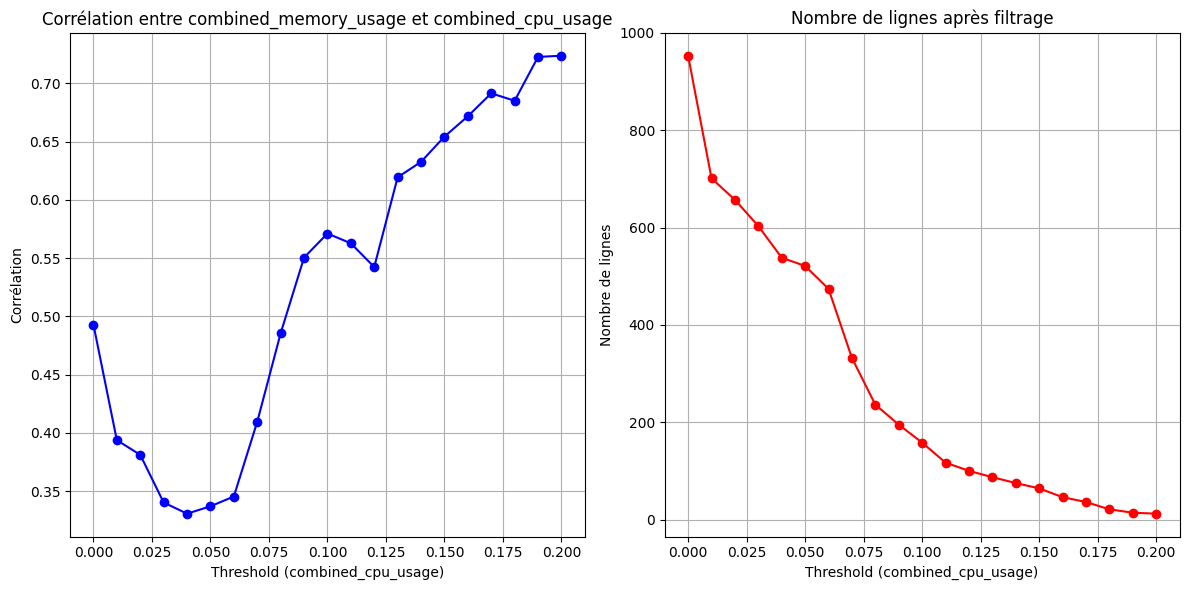

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
import matplotlib.pyplot as plt

# Initialiser une session Spark
spark = SparkSession.builder \
    .appName("Analyse Job Resource Usage") \
    .getOrCreate()

# Définition du schéma pour les fichiers CSV
job_usage_schema = StructType([
    StructField("job ID", IntegerType(), True),                 # Identifiant unique du job
    StructField("task index", IntegerType(), True),             # Identifiant unique de la task du job
    StructField("max_memory_usage", FloatType(), True),         # Mémoire maximale utilisée
    StructField("avg_memory_usage", FloatType(), True),         # Mémoire moyenne utilisée
    StructField("max_cpu_usage", FloatType(), True),            # CPU maximal utilisé
    StructField("avg_cpu_usage", FloatType(), True),            # CPU moyen utilisé
    StructField("combined_memory_usage", FloatType(), True),    # Mémoire pondéré utilisé
    StructField("combined_cpu_usage", FloatType(), True),       # CPU pondéré utilisé
    StructField("priority", IntegerType(), True),               # priorité de la task
])

# Chemin vers le fichier CSV
csv_file = "output/usage/tasks_dominants_cpu/*.csv"

# Lire le fichier CSV en un DataFrame avec le schéma défini
df_dominant_jobs = spark.read.csv(csv_file, header=True, schema=job_usage_schema)

# Créer une liste des seuils pour lesquels filtrer les jobs
thresholds = [k / 100 for k in range(0, 21, 1)]

# Dictionnaire pour stocker les DataFrames filtrés
filtered_dfs = {}

# Liste pour stocker les corrélations et les comptages
correlations = []
counts = []

# Filtrer les DataFrames pour chaque seuil
for threshold in thresholds:
    filtered_dfs[threshold] = df_dominant_jobs.filter(df_dominant_jobs["combined_cpu_usage"] >= threshold)
    count = filtered_dfs[threshold].count()
    counts.append(count)
    correlation = filtered_dfs[threshold].stat.corr("combined_memory_usage", "combined_cpu_usage")
    correlations.append((threshold, correlation))
    print(f"Threshold: {threshold}, Count: {count}, Corrélation: {correlation}")

# Tracer les résultats des corrélations
threshold_values = [t[0] for t in correlations]
correlation_values = [t[1] for t in correlations]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(threshold_values, correlation_values, marker='o', linestyle='-', color='b')
plt.title("Corrélation entre combined_memory_usage et combined_cpu_usage")
plt.xlabel("Threshold (combined_cpu_usage)")
plt.ylabel("Corrélation")
plt.grid(True)

# Tracer les résultats des comptages
plt.subplot(1, 2, 2)
plt.plot(thresholds, counts, marker='o', linestyle='-', color='r')
plt.title("Nombre de lignes après filtrage")
plt.xlabel("Threshold (combined_cpu_usage)")
plt.ylabel("Nombre de lignes")
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
spark.stop()